In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torchphysics as tp
import pytorch_lightning as pl

In [2]:
# Problem params:
x0 = [0.0, 0.5] # inital position/speed
t_end = 5 # sec
D = 1
omega_0 = 1
mu = 0.75
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable
K1 = tp.spaces.R1('k1') # parameter
K2 = tp.spaces.R1('k2') # parameter
F = tp.spaces.R1('f') # function output space name
# Domains
A_t = tp.domains.Interval(T, 0.0, t_end)
K_int = tp.domains.Interval(K1, 0, 3)
K_int2 = tp.domains.Interval(K2, 0, 2)
#Sampler
inner_sampler = tp.samplers.RandomUniformSampler(A_t, n_points = 4000)
initial_u_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()
initial_v_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()

In [3]:
# Defining function set
Fn_space = tp.spaces.FunctionSpace(A_t, F)

def f1(k1, t):
    return torch.sin(k1*t)


param_sampler = tp.samplers.RandomUniformSampler(K_int*K_int2, n_points=100)
Fn_set = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f1)

In [4]:
class DampedSine(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        alpha = 0.1
        return torch.exp(-alpha * Tensor) * torch.sin(Tensor)

# Model
dis_sampler =  tp.samplers.GridSampler(A_t, n_points = 200).make_static()
trunk_net = tp.models.FCTrunkNet(T, U, hidden=(50, 50), output_neurons=50,
                                 xavier_gains=[3/5, 3/5, 0.0])
normalization_net = tp.models.NormalizationLayer(A_t)
branch_net = tp.models.FCBranchNet(Fn_space, U, output_neurons=50, 
                                   hidden=(100, 100, 100), 
                                   discretization_sampler=dis_sampler)
#branch_net = tp.models.Conv1DBranchNet(Fn_space, U, output_neurons=100, 
#                                       hidden=(600, 500, 250), discretization_sampler=dis_sampler)
model = tp.models.DeepONet(trunk_net, branch_net)

In [5]:
def u_constrain(u, t):
    return u * t **2 / t_end**2 + x0[1]*t + x0[0]

def ode_residual(u, f, t):
    u_con = u_constrain(u, t)
    #u_t = tp.utils.grad(u_con, t)
    #lhs = tp.utils.grad(u_t, t) + 2*D*u_t + omega_0**2 * (u_con + mu*u_con**3) 
    #print(u.shape, f.shape, t.shape)
    #return u - f
    return u

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             function_set=Fn_set, 
                                             input_sampler=inner_sampler, 
                                             name='ode_condition',
                                             residual_fn=ode_residual)

In [6]:
def initial_residual(u):
    return u - x0[0]

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                 function_set=Fn_set, 
                                                 input_sampler=initial_u_sampler, 
                                                 residual_fn=initial_residual, weight=1000)

def initial_speed_residual(u, t):
    return tp.utils.grad(u, t) - x0[1]

initial_speed_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                       function_set=Fn_set, 
                                                       input_sampler=initial_u_sampler, 
                                                       residual_fn=initial_residual, weight=1000)

In [7]:
solver = tp.solver.Solver([ode_cond])

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 50.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
50.6 K    Trainable params
0         Non-trainable params
50.6 K    Total params
0.202     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarnin

Training: 0it [00:00, ?it/s]

True
True
True
True
True


Validating: 0it [00:00, ?it/s]

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, 
                            optimizer_args={'max_iter':2, 'history_size': 100})

# here now use grid points:
ode_cond.input_sampler = tp.samplers.GridSampler(A_t, n_points=1000).make_static()
Fn_set.parameter_sampler = tp.samplers.RandomUniformSampler(K_int*K_int2, n_points=20).make_static()

solver = tp.solver.Solver(train_conditions=[ode_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=100, 
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 50.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
50.6 K    Trainable params
0         Non-trainable params
50.6 K    Total params
0.202     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

True
True


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

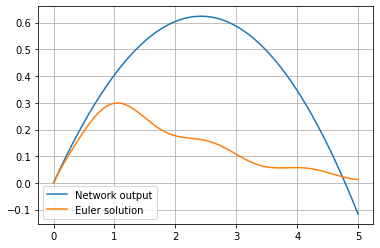

In [ ]:
import matplotlib.pyplot as plt

k0 = 4
def f(t):
    return torch.sin(k0*t) / (t+1)


model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(A_t, 2000)
grid_points = grid_sampler.sample_points()
out = u_constrain(model(grid_points).as_tensor.detach()[0], grid_points.as_tensor)
# euler:
grid_p = grid_points.as_tensor
dis_f = f(grid_p)
delta_t = grid_p[1] - grid_p[0]
u, v = torch.zeros_like(dis_f), torch.zeros_like(dis_f)
u[0] = x0[0]
v[0] = x0[1]
for i in range(len(u)-1):
    v[i+1] = v[i] + delta_t * (dis_f[i] - 2*D*v[i] - omega_0**2*(u[i] + mu * u[i]**3))
    u[i+1] = u[i] + delta_t * v[i]
plt.plot(grid_p, out)
plt.plot(grid_p, u)
plt.grid()
plt.legend(['Network output', 'Euler solution'])

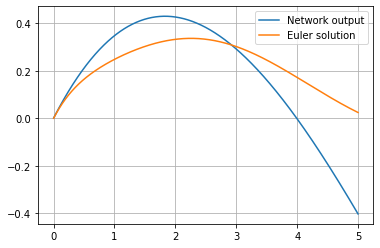

In [ ]:
import matplotlib.pyplot as plt

k0 = 1
def f(t):
    return torch.sin(k0*t) / (t+1)


model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(A_t, 2000)
grid_points = grid_sampler.sample_points()
out = u_constrain(model(grid_points).as_tensor.detach()[0], grid_points.as_tensor)
# euler:
grid_p = grid_points.as_tensor
dis_f = f(grid_p)
delta_t = grid_p[1] - grid_p[0]
u, v = torch.zeros_like(dis_f), torch.zeros_like(dis_f)
u[0] = x0[0]
v[0] = x0[1]
for i in range(len(u)-1):
    v[i+1] = v[i] + delta_t * (dis_f[i] - 2*D*v[i] - omega_0**2*(u[i] + mu * u[i]**3))
    u[i+1] = u[i] + delta_t * v[i]
plt.plot(grid_p, out)
plt.plot(grid_p, u)
plt.grid()
plt.legend(['Network output', 'Euler solution'])

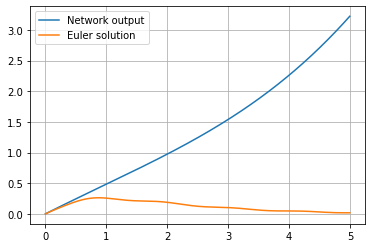

In [ ]:
import matplotlib.pyplot as plt

k0 = 5.5
def f(t):
    return torch.sin(k0*t) / (t+1)


model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(A_t, 2000)
grid_points = grid_sampler.sample_points()
out = u_constrain(model(grid_points).as_tensor.detach()[0], grid_points.as_tensor)
# euler:
grid_p = grid_points.as_tensor
dis_f = f(grid_p)
delta_t = grid_p[1] - grid_p[0]
u, v = torch.zeros_like(dis_f), torch.zeros_like(dis_f)
u[0] = x0[0]
v[0] = x0[1]
for i in range(len(u)-1):
    v[i+1] = v[i] + delta_t * (dis_f[i] - 2*D*v[i] - omega_0**2*(u[i] + mu * u[i]**3))
    u[i+1] = u[i] + delta_t * v[i]
plt.plot(grid_p, out)
plt.plot(grid_p, u)
plt.grid()
plt.legend(['Network output', 'Euler solution'])